In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
base_dir = "C:/Users/natda/Desktop/NatDave/Academics/PhD_NU/RESEARCH/BlueBikes/"

# Load cleaned trip data
cleaned_path = base_dir + "cleaned_trips.csv"
df = pd.read_csv(cleaned_path)

# Load station distance matrix
distance_matrix_path = base_dir + "station_distance_matrix.csv"
distance_matrix = pd.read_csv(distance_matrix_path)

In [3]:
# Convert started_at and ended_at columns to datetime
df["started_at"] = pd.to_datetime(df["started_at"], errors='coerce')
df["ended_at"] = pd.to_datetime(df["ended_at"], errors='coerce')

# Create temporal features
df['hour_of_day'] = df['started_at'].dt.hour
df['day_of_week'] = df["started_at"].dt.day_name()
df['day_of_week_encoded'] = df['started_at'].dt.dayofweek
df['month_of_year'] = df['started_at'].dt.month_name()
df['month_of_year_encoded'] = df['started_at'].dt.month
df['is_weekend'] = (df['day_of_week_encoded'] >= 5).astype(int)

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
df['season'] = df['started_at'].dt.month.apply(get_season)

In [4]:
# Calculate trip duration in minutes and filter invalid durations (<= 0 or > 120 minutes)
df["trip_duration_minutes"] = (df["ended_at"] - df["started_at"]).dt.total_seconds() / 60
df['trip_duration_minutes'] = df['trip_duration_minutes'].\
                              where(df['trip_duration_minutes'].between(0, 120), None)

# Print count of invalid durations and filter rows
print(f"Number of trips with unreasonable durations: {(df['trip_duration_minutes'].isna()).sum()}")
df = df[df['trip_duration_minutes'].notna()]

Number of trips with unreasonable durations: 22274


Number of trips that started and ended at the same station: 169448


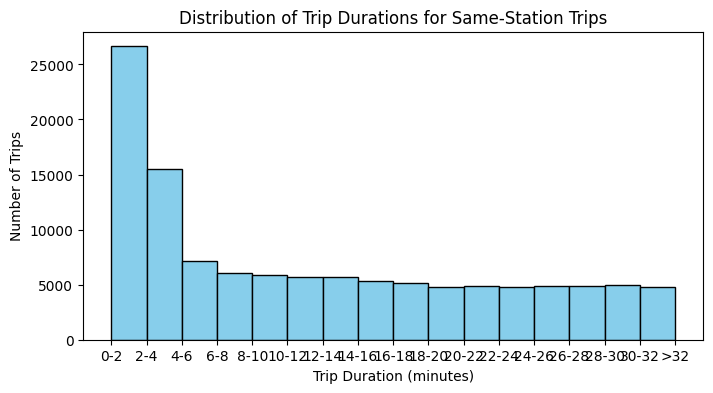

In [5]:
# Filter trips where the start and end stations are the same
same_station_trips = df[df['start_station_id'] == df['end_station_id']]

# Print the number of such trips
print(f"Number of trips that started and ended at the same station: {len(same_station_trips)}")

# Define custom bins for the histogram
bins = np.arange(0, 34, 2)
bins = np.append(bins, [np.inf])  # Adding a final bin for durations >30

# Plot the histogram
plt.figure(figsize=(8, 4))
plt.hist(same_station_trips['trip_duration_minutes'], bins=bins, color='skyblue', edgecolor='black')
plt.title('Distribution of Trip Durations for Same-Station Trips')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Number of Trips')
plt.xticks(ticks=bins[:-1], labels=[f"{int(b)}-{int(bins[i+1])}" if i < len(bins) - 2 else ">32" for i, b in enumerate(bins[:-1])])

plt.show()

In [6]:
# Remove same-station trips with duration < 5 minutes
df = df[~((df['start_station_id'] == df['end_station_id']) &
                             (df['trip_duration_minutes'] < 5))]

# Size of resulting dataset
print(f"Number of trips after removing unreasonable same-station trips: {len(df)}")

Number of trips after removing unreasonable same-station trips: 4842761


In [7]:
def calculate_trip_distance_km(row):
    start_station = row['start_station_id']
    end_station = row['end_station_id']
    try:
        distance = distance_matrix.loc[start_station, end_station]
        return distance
    except KeyError:
        return 0

df['trip_distance_km'] = df.apply(calculate_trip_distance_km, axis=1)

In [8]:
df.head()

,ride_id,bike_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,rider_type,hour_of_day,day_of_week,day_of_week_encoded,month_of_year,month_of_year_encoded,is_weekend,season,trip_duration_minutes,trip_distance_km
0,31F12D722DEC2205,traditional,2023-12-01 00:00:47,2023-12-01 00:18:32,MIT Carleton St at Amherst St,M32070,Lower Cambridgeport at Magazine St / Riverside Rd,M32022,42.360541,-71.086698,...,member,0,Friday,4,December,12,0,Winter,17.750000,0
1,C7B5105B0B65C0F3,traditional,2023-12-01 00:02:04,2023-12-01 00:07:54,MIT at Mass Ave / Amherst St,M32006,MIT Vassar St,M32042,42.358100,-71.093198,...,member,0,Friday,4,December,12,0,Winter,5.833333,0
2,68B5F2A512F98D31,traditional,2023-12-01 00:02:11,2023-12-01 00:03:15,South Station - 700 Atlantic Ave,A32010,Boston Landing,A32045,42.352175,-71.055547,...,member,0,Friday,4,December,12,0,Winter,1.066667,0
3,498C4A8C729ED986,traditional,2023-12-01 00:04:19,2023-12-01 00:14:00,One Beacon St,B32061,Columbus Ave at W. Canton St,C32077,42.358477,-71.061351,...,member,0,Friday,4,December,12,0,Winter,9.683333,0
4,2B9A06F84509E2C0,traditional,2023-12-01 00:04:38,2023-12-01 00:16:16,Silber Way,D32032,Dartmouth St at Newbury St,D32045,42.349495,-71.100575,...,member,0,Friday,4,December,12,0,Winter,11.633333,0


In [9]:
# Save the dataset with new features for reuse
feature_engineered_path = base_dir + "feature_engineered_trips.csv"
df.to_csv(feature_engineered_path, index=False)
print(f"Feature engineered data saved")

Feature engineered data saved
